EM Topic models The UCI Machine Learning dataset repository hosts several datasets recording word counts for documents here. You will use the NIPS dataset.
Cluster this to 30 topics, using a simple mixture of multinomial topic model, as lectured in class.
Produce a graph showing, for each topic, the probability with which the topic is selected.
Produce a table showing, for each topic, the 10 words with the highest probability for that topic.

In [2]:
import numpy as np
import scipy
import pandas as pd
import sklearn.cluster as sc
import matplotlib.pyplot as plt
import seaborn

In [3]:
D = 1500
W = 12419

doc_word = np.ones((D, W))

# Read doc id and word id's into a matrix
doc = open('docword.nips.txt')
lines = doc.readlines()
for line in lines[3:]:
    curr_vals = list(map(int, line.split()))
    doc_word[curr_vals[0]-1, curr_vals[1]-1] += curr_vals[2]

print("finished creating matrix")

finished creating matrix


In [4]:
#Read in vocab
vocab = []
with open('vocab.nips.txt') as f:
    for line in f:
        vocab.append(line.strip())

In [5]:
# Generate initial pi and p vectors
T = 30
w = np.zeros((D, T))
pi = np.ones(T)/T
P = np.random.random_sample((T,W))

for i in range(T):
    P[i, :] /= np.sum(P[i, :]) # Normalize

print(P)
print(pi)

[[  1.11161545e-04   2.76712931e-06   5.81877271e-05 ...,   8.16616943e-05
    6.49354230e-05   6.45306291e-05]
 [  1.54811430e-04   1.58732391e-04   1.48651970e-04 ...,   4.13710106e-05
    1.57264666e-04   1.13319670e-04]
 [  5.11403140e-05   8.64682319e-05   8.65715610e-05 ...,   4.43504987e-05
    8.18301122e-05   3.90076414e-05]
 ..., 
 [  1.79152476e-05   1.35502082e-05   1.55382849e-04 ...,   8.04836739e-05
    8.19681113e-05   1.48861400e-04]
 [  6.68340625e-05   6.41805804e-05   5.36187879e-06 ...,   6.47600511e-06
    1.46339112e-04   9.30023087e-05]
 [  1.61052482e-04   7.90860177e-05   9.59581857e-05 ...,   2.02041266e-05
    4.20132182e-05   5.57841641e-05]]
[ 0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.

In [6]:
i = 0
j = 0
top = doc_word[i,:] * np.log(P[j,:])
np.sum(top)

-136250.19967338574

In [7]:
def em_step(x, w, p, pi):
    # Find the max number
    
    # For each document
    for i in range(D):
        temp = np.zeros(T)
        # For each topic
        for l in range(T):
            # Calculate new pi values
            temp[l] = np.sum(x[i,:] * np.log(p[l,:])) + np.log(pi[l])        
            max_num = np.amax(temp)
        bottom = 0
        for l in range(T):
            # Calculate denominator of w_ij
            bottom += np.exp(temp[l] - max_num)
        for j in range(T):             
            #Calculate numerator of w_ij
            top = np.sum(x[i,:] * np.log(p[j,:])) + np.log(pi[j]) - max_num
            top = np.exp(top)
            w[i,j] = top/bottom
            
    for j in range(T):
        new_p_top = np.zeros(W)
        new_p_bot = np.zeros(W)
        # For each topic, for each document, recalculate new probabilities based on the previous probabilities
        for i in range(D):
            new_p_top += x[i] * w[i,j]
            new_p_bot += np.dot(x[i], np.ones(W)) * w[i,j]
        
        p[j,:] = new_p_top/new_p_bot
        
        sum_pi = 0.0
        for i in range(D):
            sum_pi += w[i,j]
        # New average pi_j
        pi[j] = sum_pi/D

In [8]:
count = 0
while (1):
    count = count + 1
    
    old_P = np.copy(P)
    old_pi = np.copy(pi)
    
    em_step(doc_word, w, P, pi)
    
    # Check change in p and pi after EM step
    norm_P = np.linalg.norm(P-old_P)
    norm_pi = np.linalg.norm(pi-old_pi)
    
    print(count, norm_P, norm_pi)
    # Run EM until an epsilon is reached
    if norm_P < 0.0001:
        break

1 0.0391713211805 0.285883655769
2 0.0104702138037 0.0819745344728
3 0.00510100351217 0.0414226270135
4 0.00350256572042 0.0206628695403
5 0.0031012053525 0.0155702880678
6 0.00194664733611 0.00880620983708
7 0.00279542331061 0.00720766022452
8 0.000875699107288 0.00538663716191
9 0.000594247199898 0.0031257099271
10 0.000480161301586 0.00282513620133
11 0.000504947803411 0.00195570247503
12 0.000618317085449 0.00201323967002
13 0.000708201095302 0.00285481274613
14 0.000618247079328 0.00330752884048
15 0.000161263684253 0.000806307796759
16 0.000110829229332 0.000909574383086
17 0.000145247069787 0.000950532602311
18 0.000148011957013 0.000942793781705
19 3.61231017008e-07 2.24261585493e-06


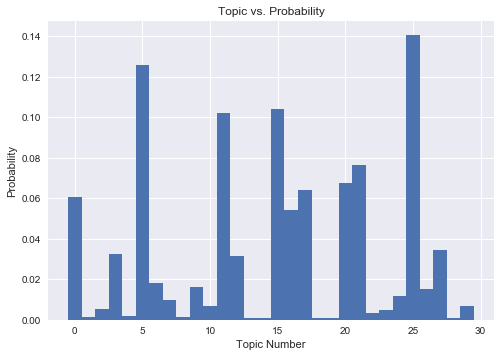

In [21]:
bar_width = 1
plt.bar(np.arange(pi.shape[0])*bar_width, pi, bar_width)
plt.title('Topic vs. Probability')
plt.xlabel('Topic Number')
plt.ylabel('Probability')
plt.show()

In [17]:
top_words = []
for t in range(T):
    # Sort words in each topic by probability
    top_ten = P[t].argsort()[-10:][::-1]
    temp_words = []
    for i in top_ten:
        # Get the top ten words
        temp_words.append(vocab[i])
    top_words.append(temp_words)


In [18]:
print(np.array(top_words))

[['neuron' 'network' 'neural' 'model' 'system' 'input' 'function' 'noise'
  'signal' 'spike']
 ['solution' 'codes' 'tap' 'method' 'message' 'case' 'code' 'system'
  'equation' 'result']
 ['model' 'motion' 'learning' 'filter' 'data' 'system' 'recognition' 'word'
  'neural' 'human']
 ['data' 'model' 'algorithm' 'set' 'point' 'vector' 'distance' 'cluster'
  'space' 'clustering']
 ['unit' 'network' 'pattern' 'training' 'input' 'function' 'learning'
  'weight' 'problem' 'number']
 ['network' 'neural' 'system' 'model' 'input' 'circuit' 'output' 'signal'
  'function' 'chip']
 ['motion' 'direction' 'cell' 'model' 'visual' 'field' 'flow' 'unit'
  'response' 'component']
 ['network' 'set' 'rules' 'rule' 'learning' 'system' 'algorithm' 'neural'
  'method' 'function']
 ['belief' 'function' 'learning' 'problem' 'states' 'network' 'approximate'
  'model' 'approximation' 'action']
 ['model' 'control' 'learning' 'movement' 'network' 'motor' 'system'
  'dynamic' 'neural' 'controller']
 ['motion' 'netwo